# Abstract

This project aims to investigate the differences in electroencephalography (EEG) signals between individuals with Alzheimer’s disease (AD) and controls. We used two datapoints from Mitiadous et al. (2023), which contains scalp EEG recordings of AD patients, and healthy controls under eyes-closed rest. In this project, we will first apply signal processing techniques including filtering and artifact rejection remove noise and isolate the frequency range of interest. Our methodology includes the application of the discrete Fourier transform (DFT) to examine spectral components, followed by the computation of power spectral density (PSD) via the Welch method. Through this approach, we aim to quantify the relative band power across different frequency bands, allowing for a detailed comparison of neural activity between the two subjects.

# Exploratory Data Analysis

Below is the dataset description provided by our TA:

>This dataset provides resting-state EEG recordings from individuals with Alzheimer’s disease (AD), frontotemporal dementia (FTD), and healthy controls, collected using a clinical EEG system with 19 scalp electrodes during an eyes-closed resting state. The dataset includes 36 AD patients, 23 FTD patients, and 29 healthy age-matched subjects, with Mini-Mental State Examination (MMSE) scores reported for each. EEG signals were recorded using a monopolar montage, and both raw and preprocessed EEG data are available in BIDS format. Preprocessing involved artifact subspace reconstruction and independent component analysis for denoising. This dataset has high reuse potential for studying EEG-based biomarkers for dementia, brain connectivity alterations, and machine learning applications in neurodegenerative disease diagnosis.
>
>- Two individual EEG data included(Alzheimer’s disease - subject_001, Healthy Control - subject_027)
>- The sampling rate was 500 Hz and the resolution was 10 uV/mm
>- Three channel included: Fp1','Fp2','F3'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

np.random.seed = 118
F_s = 500

Load in the dataset and transform it into a pandas dataframe.

In [3]:
Control = np.load("./dataset/Control_EEG_sub_027.npy")
AD = np.load("./dataset/AD_EEG_sub_001.npy")

feature_names = ['Fp1', 'Fp2', 'F3']
df_control = pd.DataFrame(Control.T, columns=feature_names)
df_AD = pd.DataFrame(AD.T, columns=feature_names)

df_AD.head()

,Fp1,Fp2,F3
0,-0.000190,-0.000142,-0.000107
1,-0.000180,-0.000137,-0.000100
2,-0.000167,-0.000135,-0.000106
3,-0.000160,-0.000133,-0.000105
4,-0.000159,-0.000124,-0.000104


Since the usual measurement for EEG studies is $\mu V$, we upscale the entire dataset by $10^6$

In [4]:
df_AD *= 1e6
df_control *= 1e6
df_AD.head()

,Fp1,Fp2,F3
0,-189.892563,-141.845688,-107.373039
1,-180.419907,-137.353500,-100.048820
2,-166.992172,-135.058578,-105.761711
3,-160.205063,-132.958969,-105.322258
4,-159.326157,-124.462883,-104.150383


Display the raw EEG data of two subjects.

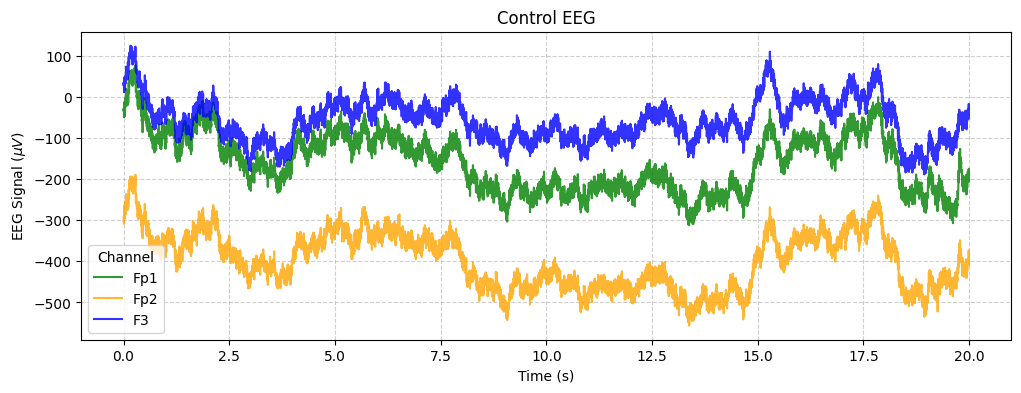

In [5]:
def plot_EEG (df,title):
    t = df.index/F_s
    plt.figure(figsize=(12, 4))
    plt.plot(t,df["Fp1"], color = "green", label = "Fp1", alpha = 0.8)
    plt.plot(t,df["Fp2"], color = "orange", label = "Fp2", alpha = 0.8)
    plt.plot(t,df["F3"], color = "blue", label = "F3", alpha = 0.8)
    plt.xlabel('Time (s)')
    plt.ylabel(r'EEG Signal $(\mu V)$')
    plt.title(title)
    plt.legend(title="Channel")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_EEG(df_control, "Control EEG")

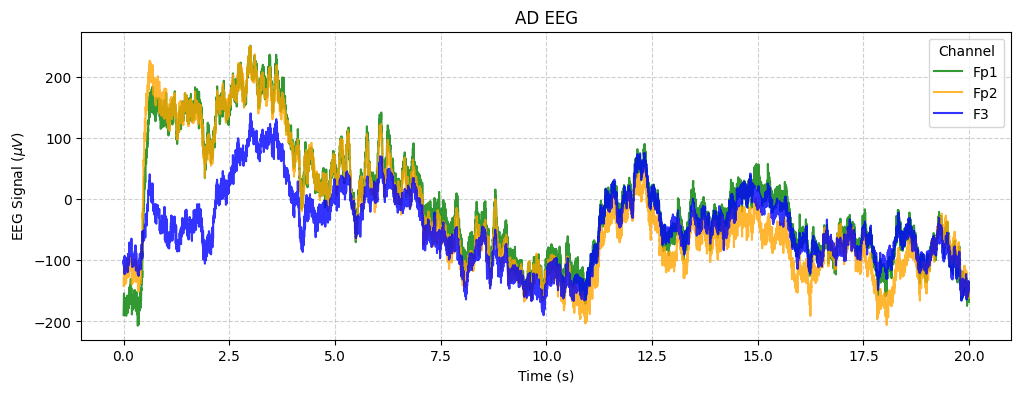

In [6]:
plot_EEG(df_AD, "AD EEG")

The unprocessed data shows signs of high-frequency noise as the range of the signal varies from $\pm 200 \mu V$, which is abnormal for calm state EEG. Preprocessing and cleaning is needed before doing further analysis.

# Preprocessing
In the original dataset paper, a preprocessing pipeline is applied as the following:

> First, a Butterworth band-pass filter 0.5-45 Hz was applied and the signals were re-referenced to A1-A2. Then, the Artifact Subspace Reconstruction routine (ASR) which is an EEG artifact correction method included in the EEGLab Matlab software was applied to the signals, removing bad data periods which exceeded the max acceptable 0.5 second window standard deviation of 17, which is considered a conservative window. Next, the Independent Component Analysis (ICA) method (RunICA algorithm) was performed, transforming the 19 EEG signals to 19 ICA components. ICA components that were classified as “eye artifacts” or “jaw artifacts” by the automatic classification routine “ICLabel” in the EEGLAB platform were automatically rejected. It should be noted that, even though the recording was performed in a resting state, eyes-closed condition, eye artifacts of eye movement were still found at some EEG recordings.

Since we were only given 20-second data of 2 subjects with 3 channels, we are unable to perform complex cleaning methods like ICA. Luckily we can still construct a butter band-pass filter, which will effectively remove slow drifts and high-frequency noise.

In [7]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, data)


lowcut = 0.5
highcut = 45

for col in df_control.columns:
    df_control[col] = butter_bandpass_filter(df_control[col], lowcut, highcut, F_s)

for col in df_AD.columns:
    df_AD[col] = butter_bandpass_filter(df_AD[col], lowcut, highcut, F_s)

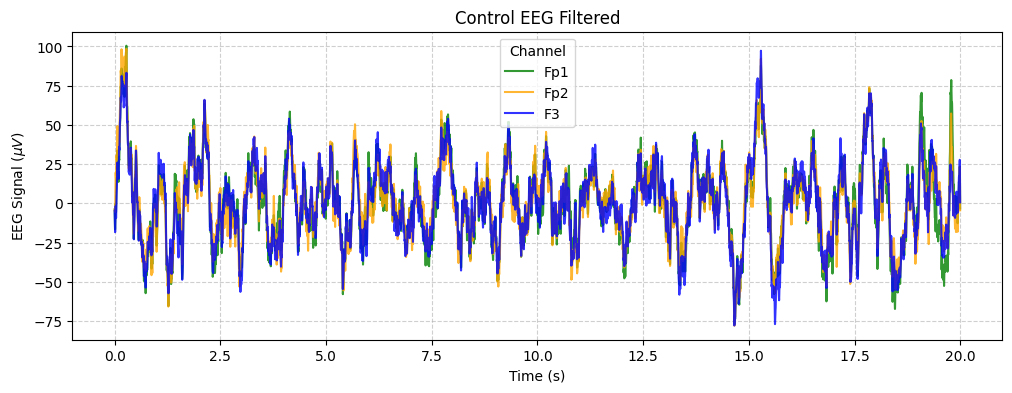

In [8]:
plot_EEG(df_control, "Control EEG Filtered")

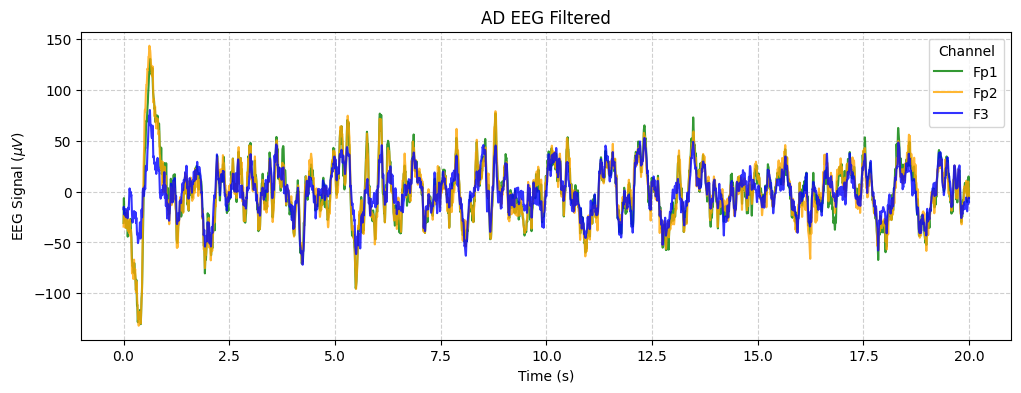

In [9]:
plot_EEG(df_AD, "AD EEG Filtered")

# PSD Analysis

To analyze the and compare the EEG signals from Alzheimer's patients and control subjects, we do a Power Spectral Density (PSD) analysis. This will show us how power is distributed across different frequencies, revealing key features related to brain activity. To estimate the PSD, we use __Welch's Method__, which reduces noise and provides a smoother estimate by averaging multiple segments of the signal. This allows us to compare the power across different frequency bands while minimizing variability. 

We'll first create a function to calculate the PSD and plot the PSD for all 3 EEG channels (`Fp1`, `Fp2`, `F3`). 

In [10]:
def plot_PSD_welch(df, title, nperseg):
    freqs, psd_Fp1 = welch(df["Fp1"].values, fs=F_s, nperseg=nperseg)
    _, psd_Fp2 = welch(df["Fp2"].values, fs=F_s, nperseg=nperseg)
    _, psd_F3 = welch(df["F3"].values, fs=F_s, nperseg=nperseg)

    plt.figure(figsize=(8, 5))
    plt.plot(freqs, psd_Fp1, label="Fp1", color = "green", alpha=0.8)
    plt.plot(freqs, psd_Fp2, label="Fp2", color = "orange", alpha=0.8)
    plt.plot(freqs, psd_F3, label="F3", color = "blue", alpha=0.8)

    plt.xlabel("Frequency (Hz)")
    plt.xlim(0, 15)
    plt.ylabel(r"Power Spectral Density ($\mu V^2$/Hz)")
    plt.title(title)
    plt.grid(linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

We then call the `plot_PSD_welch` function to estimate and plot the PSD for the dataset with Alzheimer's Patients.

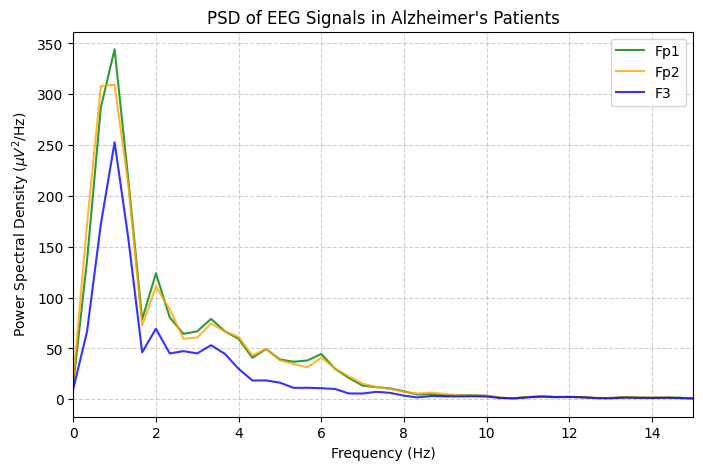

In [11]:
plot_PSD_welch(df_AD, "PSD of EEG Signals in Alzheimer's Patients",1500)

Again, we call the `plot_PSD_welch` function to estimate and plot the PSD but for the dataset with the Control subjects .

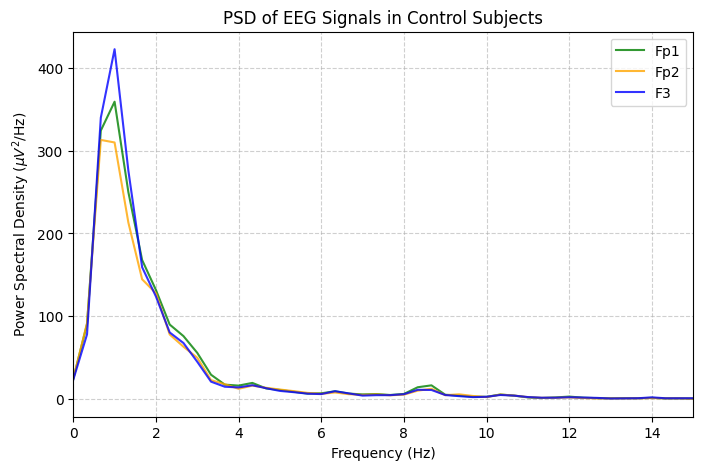

In [12]:
plot_PSD_welch(df_control, "PSD of EEG Signals in Control Subjects", 1500)

# FFT-based PSD Analysis

To complement Welch's method, we use the Fast __Fourier Transform (FFT)__ which converts time-domain EEG signals into the frequency domain, allowing us to estimate the __Power Spectral Density (PSD)__. Unlike Welch's method, which averages overlapping segments of the signal to reduce noise, FFT-based PSD provides a direct computation with higher frequency resolution which may introduce more variability due to the lack of averaging. Both methods use the same spectral characteristics, which confirms the validity of our results and ensures that the observed EEG slowing in Alzheimer's patients is a strong finding.

First we define the function `compute_psd_fft()`, which calcluates the PSD by applying the FFT to the EEG signal, and then use `plot_PSD_fft()` to visualize the FFT-based PSD for each EEG channel (Fp1, Fp2, F3). This provides a frequency-domain representation of brain activity and allows us to compare spectral differences between Alzheimer's patients and control subjects.

In [13]:
def compute_psd_fft(signal, fs):
    N = len(signal)
    fft_vals = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(N, d=1/fs)
    psd = (np.abs(fft_vals) ** 2) / N
    return fft_freqs, psd

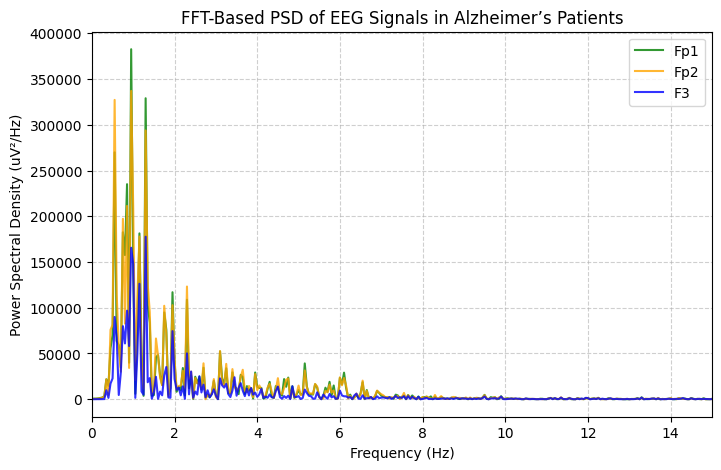

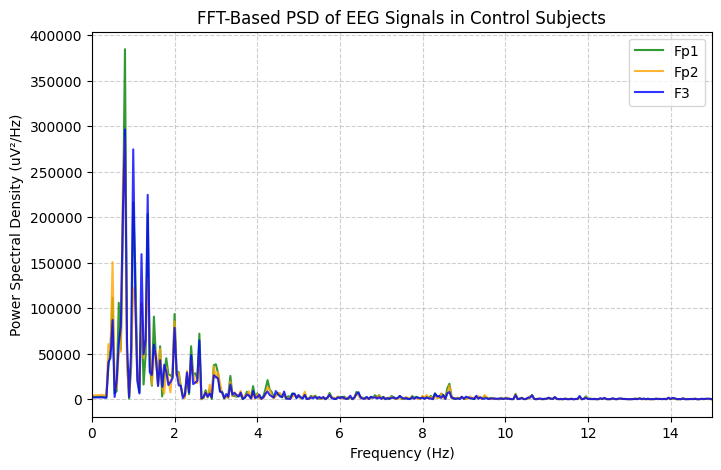

In [14]:
def plot_PSD_fft(df, title):
    freqs_Fp1, psd_Fp1 = compute_psd_fft(df["Fp1"].values, F_s)
    freqs_Fp2, psd_Fp2 = compute_psd_fft(df["Fp2"].values, F_s)
    freqs_F3, psd_F3 = compute_psd_fft(df["F3"].values, F_s)

    plt.figure(figsize=(8, 5))
    plt.plot(freqs_Fp1, psd_Fp1, label="Fp1", color="green", alpha=0.8)
    plt.plot(freqs_Fp2, psd_Fp2, label="Fp2", color="orange", alpha=0.8)
    plt.plot(freqs_F3, psd_F3, label="F3", color="blue", alpha=0.8)

    plt.xlabel("Frequency (Hz)")
    plt.xlim(0, 15)
    plt.ylabel("Power Spectral Density (uV²/Hz)")
    plt.title(title)
    plt.grid(linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

plot_PSD_fft(df_AD, "FFT-Based PSD of EEG Signals in Alzheimer’s Patients")
plot_PSD_fft(df_control, "FFT-Based PSD of EEG Signals in Control Subjects")